In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import hyp2f1

In [23]:
T = 1.5
n = 500
times = np.linspace(0, T, n + 1)

repeat = 100000

# Zn1 has shape (repeat, n)
Zn1 = np.random.multivariate_normal(
        np.zeros(n), np.eye(n), repeat)  # une fois pour tout (invariant by eta and lam)
Zn2 = np.random.multivariate_normal(
        np.zeros(n), np.eye(n), repeat)

w1 = np.cumsum(Zn1 * np.sqrt(T/n), axis=1)
w2 = np.cumsum(Zn2 * np.sqrt(T/n), axis=1)

In [25]:
# Exp Kernel-Cholesky for XT

def Sigma_exp(t, s, eta, lam):
    return (
        eta**2
        / (2 * lam)
        * np.exp(-lam * (s + t))
        * (np.exp(2 * lam * np.minimum(s, t)) - 1)
    )

def covariance_exp(T, n, eta, lam):
    '''Return the covariance Sigma for exponential kernel.
    '''
    cov = np.zeros((n, n))
    for i in range(n):
        cov[i, :] = Sigma_exp(times[1+i], times[1:], eta=eta, lam=lam)
    return cov


In [26]:
# Frac Kernel-XT

def aux_integral_function(x,k,a):
    return x*(k+x**2)**a*((k+x**2)/k)**(-a)*hyp2f1(0.5, -a, 1.5, -x**2/k)

def Sigma_frac(t, s, H, c):
    a = H-0.5
    if t==s:
        return 2*(t/2)**(2*a+1)/(2*a+1)
    else:
        k = 0.25*(s-t)**2
        xmin = - 0.5*(s+t)
        xmax = np.minimum(t,s) + xmin
        return aux_integral_function(xmax, k, a) - aux_integral_function(xmin, k, a)

def covariance_frac(T, n, H, c):

    cov = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            cov[i, j] = Sigma_frac(times[1+i], times[1+j], H=H, c=c)
    return cov


In [27]:

def sample_XT_Cholesky(lam, eta, Zns=Zn1):

    cov = covariance_exp(T, n, eta, lam)
    L = np.linalg.cholesky(cov)
    # t begins from t1=T/n but not t0=0
    sample = Zns @ L.T

    # mean = np.mean(sample[:, -1])
    # var = np.var(sample[:, -1])
    # demi_width_IC = np.sqrt(var/repeat) * 1.96
    
    # print(f"X_T: mean={mean:3.3f} var={var:3.3f} ({Sigma_exp(t=T,s=T, eta=eta, lam=lam):3.3f})")
    # print("IC(95%%) = [%1.3f, %1.3f] \n" \
    #   %(mean-demi_width_IC, mean + demi_width_IC))
    
    return sample, cov

def sample_XT_cumsum(lam, eta, Zns=Zn1):
    
    sigma = eta * np.sqrt(np.exp(2*lam*times[:-1])*(np.exp(2*lam*T/n)-1)/(2*lam))
    sample = np.exp(-lam*times[1:]) * np.cumsum(Zns*sigma, axis=1)

    # mean = np.mean(sample[:, -1])
    # var = np.var(sample[:, -1])
    # demi_width_IC = np.sqrt(var/repeat) * 1.96
    
    # print(f"X_T: mean={mean:3.3f} var={var:3.3f} ({Sigma_exp(t=T,s=T, eta=eta, lam=lam):3.3f})")
    # print("IC(95%%) = [%1.3f, %1.3f] \n" \
    #   %(mean-demi_width_IC, mean + demi_width_IC))
    
    return sample
    

def sample_XT_frac(H, c, Zns=Zn1):

    cov = covariance_frac(T, n, H, c)
    L = np.linalg.cholesky(cov)
    
    sample =  Zns @ L.T

    mean = np.mean(sample[:, -1])
    var = np.var(sample[:, -1])
    demi_width_IC = np.sqrt(var/repeat) * 1.96
    
    print(f"X_T: mean={mean:3.3f} var={var:3.3f} ({Sigma_frac(T,T, H, c):3.3f})")
    print("IC(95%%) = [%1.3f, %1.3f] \n" \
      %(mean-demi_width_IC, mean + demi_width_IC))
    
    return sample, cov

In [15]:
sample_XT_Cholesky(lam=1, eta=1)
sample_XT_cumsum(lam=1, eta=1)
sample_XT_frac(H=0.5, c=1)
print("")

X_T: mean=-0.006 var=0.479 (0.475)
IC(95%) = [-0.010, -0.002] 

X_T: mean=-0.006 var=0.479 (0.475)
IC(95%) = [-0.010, -0.002] 

X_T: mean=-0.011 var=1.508 (1.500)
IC(95%) = [-0.018, -0.003] 




In [28]:
%%timeit
sample_XT_cumsum(lam=1, eta=1)

894 ms ± 229 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
%%timeit
sample_XT_Cholesky(lam=1, eta=1)

1.07 s ± 90.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
def plot_sample(sample, ylabel="${X_T}$", title=f"Sample of XT with n={n}", save_pic=False):
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(times[1:], sample.T, "-")

    ax.set_xlabel("time t")
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.show()
    if save_pic:
        plt.savefig(title)

In [10]:
def sample_B(rho=0.5):
    sample = rho*w1+np.sqrt(1-rho**2)*w2
    
    mean = np.mean(sample[:, -1])
    var = np.var(sample[:, -1])
    demi_width_IC = np.sqrt(var/repeat) * 1.96
    
    print(f"B_T: mean={mean:3.3f} var={var:3.3f} ({T:3.3f})")
    print("IC(95%%) = [%1.3f, %1.3f] \n" \
      %(mean-demi_width_IC, mean + demi_width_IC))
    
    return sample

B_T: mean=-0.001 var=1.494 (1.500)
IC(95%) = [-0.009, 0.006] 



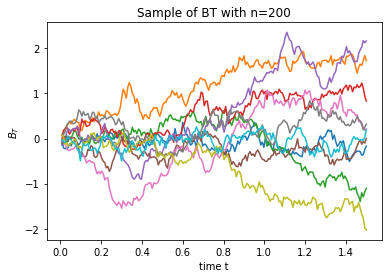

In [11]:
plot_sample(sample_B(rho=0)[:10], ylabel="${B_T}$", title=f"Sample of BT with n={n}")
print("")

In [38]:
def Sigma(X, vars):
    ksi = 0.5
    a0 = 1
    a1 = 1
    return ksi*(a0 + a1*X) / np.sqrt(a0**2 + a1**2*vars)

In [39]:
def sample_S(rho=0.5, eta=1, lam=1, S0=100):
    
    X_sample, cov = sample_XT_Cholesky(lam=lam, eta=eta)
    vars = np.diagonal(cov)

    sigma = Sigma(X_sample, vars)

    B_sample = sample_B(rho=rho)
    sum1 = np.cumsum(0.5*(sigma[:, :-1]**2+sigma[:, 1:]**2)*T/n, axis=1)
    sum2 = np.cumsum((sigma[:, :-1])*(B_sample[:, 1:]-B_sample[:,:-1]), axis=1)
    sample = S0*np.exp(-0.5*sum1+sum2)
    
    mean = np.mean(sample[:, -1])
    var = np.var(sample[:, -1])
    demi_width_IC = np.sqrt(var/repeat) * 1.96
    print(f"S_T: mean={mean:3.3f} var={var:3.3f}")
    print("IC(95%%) = [%1.3f, %1.3f] \n" \
      %(mean-demi_width_IC, mean + demi_width_IC))
         
    return sample

B_T: mean=0.006 var=1.494 (1.500)
IC(95%) = [-0.002, 0.013] 

S_T: mean=100.141 var=2643.749
IC(95%) = [99.822, 100.460] 



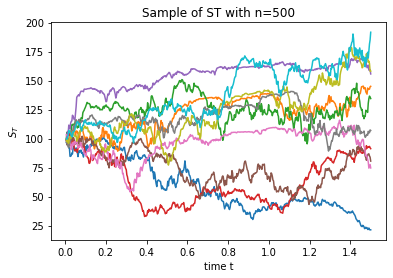

In [40]:
sample = sample_S(rho=-0.8)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(times[2:], sample[:10].T, "-")

ax.set_xlabel("time t")
ax.set_ylabel("${S_T}$")
ax.set_title(f"Sample of ST with n={n}")
plt.show()
